# Deepmind TurnerLab (Pillar IV) Dataset 06-07-2023

**Data Source:** *16FlYMaze System, Turner Lab, HHMI Janelia Research Campus*

**Collected By:** *Kaitlyn Boone, Aparna Dev, PTR, HHMI Janelia Research Campus*

**Code Author:** *Rishika Mohanta*


In [1]:
# LIBRARY IMPORTS

# import libraries
import numpy as np                      # for numerical operations
import pandas as pd                     # for data manipulation
import matplotlib.pyplot as plt         # for plotting
import scipy.optimize as opt            # for optimization
from joblib import Parallel, delayed    # for parallelization
from tqdm.notebook import tqdm          # for progress bar
import pickle                           # for saving and loading
import os                               # for file operations
import gzip                             # for compressing files 
import torch                            # for neural networks
import torch.nn as nn                   # for neural networks
import torch.nn.functional as F         # for neural networks
from torch.utils.data import TensorDataset, DataLoader # for neural networks
import copy                             # for copying objects

# import statistics modules
from scipy.stats import wilcoxon       # for wilcoxon signed-rank test
from sklearn.cluster import AgglomerativeClustering # for clustering
from scipy.optimize import minimize

# import cognitive models
from pygorl.cogpolicy import *     # Cognitive Policy Learning models
from pygorl.cogq import *          # Cognitive Q-learning models

# import sklearn modules
from sklearn.linear_model import LogisticRegression # for logistic regression

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.colors as colors      # for truncating colormaps

# define function for truncating colormaps
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# define truncated colormap of RdYlGn for Orange-Green
OrGn = truncate_colormap(plt.get_cmap('RdYlGn'), 0.3, 0.9)

# statistical tests
from scipy import stats

def pairedRankBiserialCorrelation(x,y):
    """ Calculate the paired rank biserial correlation for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    # calculate the signed rank
    signed_rank = np.sign(x-y)*stats.rankdata(np.abs(x-y))
    # get sum of positive and negative ranks
    pos_rank = np.sum(signed_rank[signed_rank>0])
    neg_rank = -np.sum(signed_rank[signed_rank<0])
    # calculate the proportion of positive and negative ranks
    pos_prop = pos_rank/(pos_rank+neg_rank)
    neg_prop = neg_rank/(pos_rank+neg_rank)
    # calculate the difference in proportion
    return pos_prop-neg_prop

def cohensd(x,y):
    """
    Calculate Cohen's d
    """
    # calculate the size of samples
    n1, n2 = len(x), len(y)
    # calculate the variance of the samples
    s1, s2 = np.var(x, ddof=1), np.var(y, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2))
    # calculate the means of the samples
    u1, u2 = np.mean(x), np.mean(y)
    # calculate the effect size
    return (u1 - u2) / s


In [2]:
data_path = '../data/dmData_14-09-2023/' # path to data files
fit_path = '../processed_data/dmData_14-09-2023/' # path to fitted models
quality_control = 'full' # whether to perform quality control (valid options: minimal, full, none)
last_date = '2024-06-10 00:00:00' # last date of data collection
recalculate = False # whether to recalculate all data (True) or load from file (False)

In [3]:
# DATA LOADING

# load data
choice_data = np.loadtxt(data_path + 'choices.csv', delimiter=',')
reward_data = np.loadtxt(data_path + 'rewards.csv', delimiter=',')
trial_duration_data = np.loadtxt(data_path + 'trial_lengths.csv', delimiter=',')

# turn into integers
choice_data = choice_data.astype(int)
reward_data = reward_data.astype(int)
trial_duration_data = trial_duration_data.astype(float)

if choice_data.shape != reward_data.shape or choice_data.shape != trial_duration_data.shape:
    raise ValueError('Sizes do not match.')

N = choice_data.shape[0]    # number of flies

print("Data loaded successfully with N = {} flies and {} maximum trials".format(N, choice_data.shape[1]))

# load metadata
metadata = pd.read_csv(data_path + 'metadata.csv')
metadata['Experiment Start Time'] = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')
metadata['Starvation Time'] = pd.to_datetime(metadata['Starvation Time'], format='%Y-%m-%d %H:%M:%S')

# load quality control data
qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)

Data loaded successfully with N = 446 flies and 1318 maximum trials


/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_28051/550774320.py:9: RuntimeWarning: invalid value encountered in cast
  choice_data = choice_data.astype(int)
/var/folders/yj/5_b3w2q176x67w94977kdrx80000gn/T/ipykernel_28051/550774320.py:10: RuntimeWarning: invalid value encountered in cast
  reward_data = reward_data.astype(int)


In [4]:
# remove all control flies
choice_data = choice_data[metadata['Fly Experiment'] != 'control.csv']
reward_data = reward_data[metadata['Fly Experiment'] != 'control.csv']
trial_duration_data = trial_duration_data[metadata['Fly Experiment'] != 'control.csv']
qc = qc[metadata['Fly Experiment'] != 'control.csv']
metadata = metadata[metadata['Fly Experiment'] != 'control.csv']
choice_data = choice_data[metadata['Fly Experiment'] != 'control_reciprocal.csv']
reward_data = reward_data[metadata['Fly Experiment'] != 'control_reciprocal.csv']
trial_duration_data = trial_duration_data[metadata['Fly Experiment'] != 'control_reciprocal.csv']
qc = qc[metadata['Fly Experiment'] != 'control_reciprocal.csv']
metadata = metadata[metadata['Fly Experiment'] != 'control_reciprocal.csv']
metadata.reset_index(drop=True, inplace=True)

# QUALITY CONTROL

if quality_control == 'minimal':
    choice_data = choice_data[qc]
    reward_data = reward_data[qc]
    trial_duration_data = trial_duration_data[qc]
    metadata = metadata[qc]
    metadata.reset_index(drop=True, inplace=True)
if quality_control == 'full':
    metadata = metadata[qc]
    metadata = metadata[metadata['Experiment Start Time'] < last_date].groupby('Fly Experiment').head(3)
    choice_data = choice_data[metadata.index]
    reward_data = reward_data[metadata.index]
    trial_duration_data = trial_duration_data[metadata.index]
    metadata.reset_index(drop=True, inplace=True)

print("{}/{} ({}) flies passed quality control".format(choice_data.shape[0], N, "{:0.2f}".format(choice_data.shape[0]/N*100)))

N = choice_data.shape[0]    # number of flies

360/446 (80.72) flies passed quality control


In [5]:
def get_probabilities(fly_no,return_trial_count=False):
    exp_name = metadata['Fly Experiment'][fly_no]
    exp_data = pd.read_csv(data_path+'experiments/'+exp_name)
    trial_count = sum(choice_data[fly_no,:] >= 0)
    # get probability of choosing reward for each odor
    p_1 = exp_data['P(R|O1)'].values[:trial_count]
    p_2 = exp_data['P(R|O2)'].values[:trial_count]
    if return_trial_count:
        return p_1, p_2, trial_count
    else:
        return p_1, p_2

def get_blocks(fly_no,return_n_blocks=False):
    """
    Get blocks for a given fly
    """
    p_1, p_2, trial_count = get_probabilities(fly_no,return_trial_count=True)
    # get block transitions
    block_transitions = np.logical_or(np.diff(p_1) != 0, np.diff(p_2) != 0)
    n_blocks = np.sum(block_transitions)
    block_transitions = np.concatenate(([0], block_transitions)) # account for first trial
    block_no = np.cumsum(block_transitions) # block number for each trial
    # loop over blocks
    block_data = []
    for b in np.unique(block_no):
        p_1_b = np.unique(p_1[block_no == b])[0]
        p_2_b = np.unique(p_2[block_no == b])[0]
        n_trials = np.sum(block_no == b)
        choices = choice_data[:,:trial_count][fly_no,block_no == b]
        rewards = reward_data[:,:trial_count][fly_no,block_no == b]
        block_length = np.sum(block_no == b)
        block_data.append({'p_1':p_1_b, 'p_2':p_2_b, 'choices':choices, 'rewards':rewards, 'block_length':block_length})
    return (block_data, n_blocks) if return_n_blocks else block_data

In [6]:
# Helper Functions for Dataset

def get_valid_data(x):
    # check if x in a numpy array
    if not isinstance(x, np.ndarray):
        x_ = np.array(x)
    else:
        x_ = x.copy()
    x_ = x_[~np.isnan(x_)]
    x_ = x_[~np.isinf(x_)]
    x_ = x_[x_>=0]
    return x_

def get_split_data(choices=choice_data, rewards=reward_data, K=2):
    """
    Get the split choice and reward data for a given number of folds.
    
    Parameters
    ----------
    choices : numpy.ndarray
        The choice data.
    rewards : numpy.ndarray
        The reward data.
    K : int
        The number of folds.
    """
    vals = []
    for i in range(K):
        cs_temp = choices[i::K]
        cs = []
        for c in cs_temp:
            cs += [get_valid_data(c)]
        rs_temp = rewards[i::K]
        rs = []
        for r in rs_temp:
            rs += [get_valid_data(r)]
        vals.append((cs, rs))
    return vals

def log_likelihood(predictions,observations):
    """
    Calculate the bernoulli log likelihood of the observation given the prediction.

    Parameters
    ----------
    predictions : numpy.ndarray
        The predictions.
    observations : numpy.ndarray
        The observations.
    """
    lls = []
    assert len(predictions) == len(observations), "The number of predictions and observations must be the same."
    for i in range(len(predictions)):
        lls += [np.sum(np.log(predictions[i])*observations[i]+np.log(1-predictions[i])*(1-observations[i]))]
    return lls

def normalized_log_likelihood(predictions,observations):
    """
    Calculate the normalized bernoulli log likelihood of the observation given the prediction.

    Parameters
    ----------
    predictions : numpy.ndarray
        The predictions.
    observations : numpy.ndarray
        The observations.
    """
    norm_lls = []
    assert len(predictions) == len(observations), "The number of predictions and observations must be the same."
    for i in range(len(predictions)):
        norm_lls += [np.exp(np.mean(np.log(predictions[i])*observations[i]+np.log(1-predictions[i])*(1-observations[i])))]
    return norm_lls

# Storing all data directories
all_models = {}

# create fit directory if it doesn't exist
if not os.path.exists(fit_path):
    os.makedirs(fit_path)
    os.makedirs(fit_path + 'fit_results/')


Do simple trial time analysis to see if trial which repeat the last choice are more likely to be faster than trials that switch the choice.

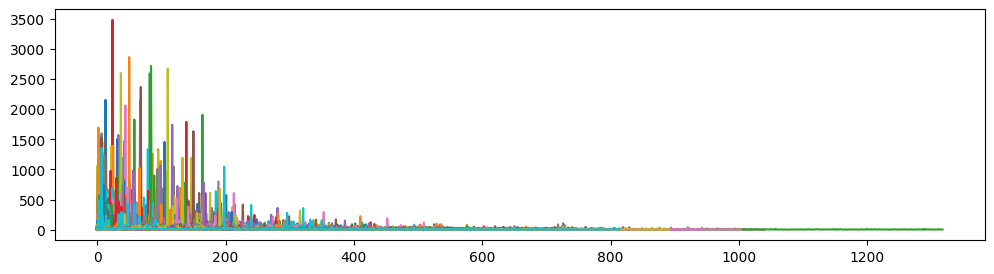

In [7]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in range(N):
    ax.plot(trial_duration_data[i][~np.isnan(trial_duration_data[i])], '-')

## Whole Period

Trial durations for same choices: median = 10.42, mad = 3.68
Trial durations for diff choices: median = 9.68, mad = 3.24


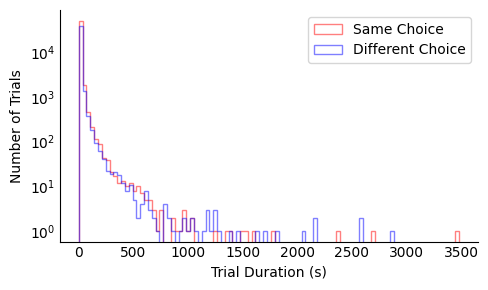

Bootstrap analysis for trial durations


  0%|          | 0/1000 [00:00<?, ?it/s]

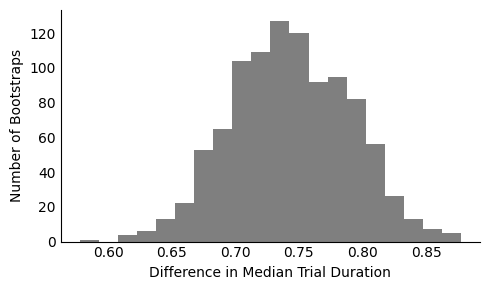

95% confidence interval = [0.65448741 0.83241382]
p-value = 0.0
Trial duration change for same choices: median = -2.70, mad = 29.47
Trial duration change for diff choices: median = -1.07, mad = 29.54


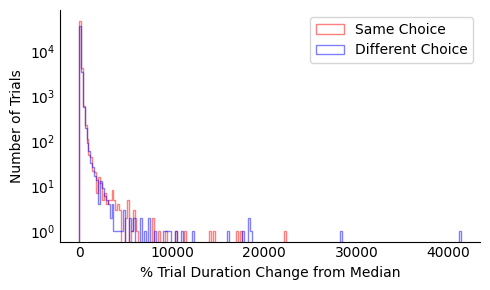

Bootstrap analysis for trial duration change


  0%|          | 0/1000 [00:00<?, ?it/s]

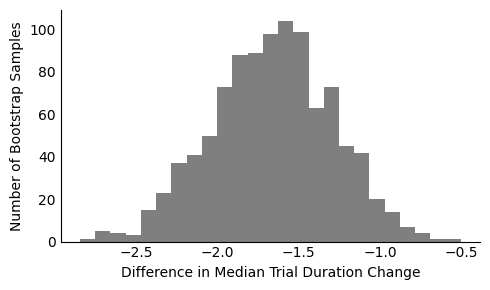

95% confidence interval = [-2.40185279 -0.96520701]
p-value = 0.0


In [10]:
same = []
diff = []
same_change = []
diff_change = []
for i in range(N):
    # get choices and trial durations
    c = choice_data[i]
    r = reward_data[i]
    t = trial_duration_data[i]
    # get valid choices
    c = get_valid_data(c)
    r = get_valid_data(r)
    t = t[~np.isnan(t)]
    # assert that choices and trial durations are the same length
    assert len(c) == len(t) and len(r) == len(t), "Choice, reward, and trial duration data must be the same length."

    # loop over trials starting from the second trial
    for j in range(1,len(c)):
        # if the current choice is the same as the previous choice
        t_past_window = t[max(0,j-45):j][1:]
        r_past_window = r[max(0,j-45):j][:-1]
        c_past_window = c[max(0,j-45):j][:-1]
        median_for_unrewarded = np.median(t_past_window[np.logical_and(r_past_window==0,c_past_window==c[j-1])])
        if c[j] == c[j-1] and r[j-1] == 0:  # cannot consider the previous trial if it was rewarded due to local search increasing the trial duration
            same.append(t[j])
            if median_for_unrewarded == 0 or np.isnan(median_for_unrewarded):
                same_change.append(np.nan)
            else:
                same_change.append((t[j]-median_for_unrewarded)/median_for_unrewarded*100)
        elif c[j] != c[j-1] and r[j-1] == 0:
            diff.append(t[j])
            if median_for_unrewarded == 0 or np.isnan(median_for_unrewarded):
                diff_change.append(np.nan)
            else:
                diff_change.append((t[j]-median_for_unrewarded)/median_for_unrewarded*100)
same = np.array(same)
diff = np.array(diff)
same_change = np.array(same_change)
diff_change = np.array(diff_change)

# remove nans
same = same[~np.isnan(same)]
diff = diff[~np.isnan(diff)]
same_change = same_change[~np.isnan(same_change)]
diff_change = diff_change[~np.isnan(diff_change)]

# get overall maximum trial duration
min_trial_duration = np.min([np.min(same), np.min(diff)])
max_trial_duration = np.max([np.max(same), np.max(diff)])
bins = np.linspace(min_trial_duration, max_trial_duration, 100)

print("Trial durations for same choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(same), np.median(np.abs(same-np.median(same)))))
print("Trial durations for diff choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(diff), np.median(np.abs(diff-np.median(diff)))))

# plot histogram (step plot)
plt.figure(figsize=(5,3))
plt.hist(same, bins=bins, color='red', alpha=0.5, label='Same Choice', histtype='step')
plt.hist(diff, bins=bins, color='blue', alpha=0.5, label='Different Choice', histtype='step')
plt.xlabel('Trial Duration (s)')
plt.ylabel('Number of Trials')
plt.yscale('log')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

# minimum size of same and diff
print("Bootstrap analysis for trial durations")
n_bootstrap = 1000
diff_bootstrap = []
for i in tqdm(range(n_bootstrap)):
    bootstrap_same = np.random.choice(same, size=same.shape[0], replace=True)
    bootstrap_diff = np.random.choice(diff, size=diff.shape[0], replace=True)
    diff_bootstrap.append(np.median(bootstrap_same)-np.median(bootstrap_diff))
diff_bootstrap = np.array(diff_bootstrap)
# plot histogram
plt.figure(figsize=(5,3))
plt.hist(diff_bootstrap, bins=20, color='black', alpha=0.5)
plt.xlabel('Difference in Median Trial Duration')
plt.ylabel('Number of Bootstraps')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()
print("95% confidence interval = {}".format(np.percentile(diff_bootstrap, [2.5, 97.5])))
print("p-value = {}".format(np.mean(diff_bootstrap<0)))

# get overall maximum trial duration change and minimum trial duration change
min_trial_duration_change = np.min([np.min(same_change), np.min(diff_change)])
max_trial_duration_change = np.max([np.max(same_change), np.max(diff_change)])
bins = np.linspace(min_trial_duration_change, max_trial_duration_change, 200)

print("Trial duration change for same choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(same_change), np.median(np.abs(same_change-np.median(same_change)))))
print("Trial duration change for diff choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(diff_change), np.median(np.abs(diff_change-np.median(diff_change)))))

# plot histogram (step plot)
plt.figure(figsize=(5,3))
plt.hist(same_change, bins=bins, color='red', alpha=0.5, label='Same Choice', histtype='step')
plt.hist(diff_change, bins=bins, color='blue', alpha=0.5, label='Different Choice', histtype='step')
plt.xlabel('% Trial Duration Change from Median')
plt.ylabel('Number of Trials')
plt.yscale('log')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

# minimum size of same and diff
print("Bootstrap analysis for trial duration change")
n_bootstrap = 1000
diff_bootstrap = []
for i in tqdm(range(n_bootstrap)):
    bootstrap_same = np.random.choice(same_change, size=same_change.shape[0], replace=True)
    bootstrap_diff = np.random.choice(diff_change, size=diff_change.shape[0], replace=True)
    diff_bootstrap.append(np.median(bootstrap_same)-np.median(bootstrap_diff))
diff_bootstrap = np.array(diff_bootstrap)
# plot histogram
plt.figure(figsize=(5,3))
plt.hist(diff_bootstrap, bins=25, color='black', alpha=0.5)
plt.xlabel('Difference in Median Trial Duration Change')
plt.ylabel('Number of Bootstrap Samples')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()
print("95% confidence interval = {}".format(np.percentile(diff_bootstrap, [2.5, 97.5])))
print("p-value = {}".format(np.mean(diff_bootstrap>0)))

## Only Naive Period

Trial durations for same choices: median = 13.43, mad = 6.81
Trial durations for diff choices: median = 14.04, mad = 7.20


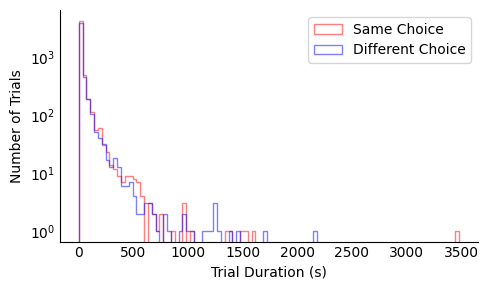

Bootstrap analysis for trial durations


  0%|          | 0/10000 [00:00<?, ?it/s]

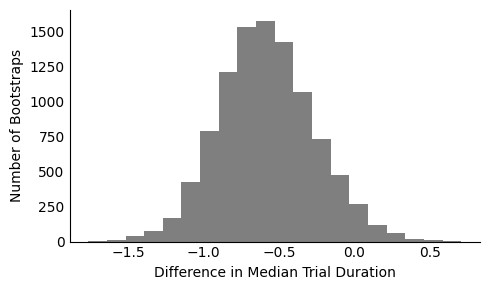

95% confidence interval = [-1.17435827  0.06635213]
p-value = 0.0405


In [8]:
same = []
diff = []
for i in range(N):
    # get choices and trial durations
    c = choice_data[i]
    r = reward_data[i]
    t = trial_duration_data[i]
    # get valid choices
    c = get_valid_data(c)
    r = get_valid_data(r)
    t = t[~np.isnan(t)]
    # assert that choices and trial durations are the same length
    assert len(c) == len(t) and len(r) == len(t), "Choice, reward, and trial duration data must be the same length."
    # keep only naive period
    c = c[:30]
    r = r[:30]
    t = t[:30]

    # loop over trials starting from the second trial
    for j in range(1,len(c)):
        # if the current choice is the same as the previous choice
        if c[j] == c[j-1]:
            same.append(t[j])
        elif c[j] != c[j-1] and r[j-1] == 0:
            diff.append(t[j])

same = np.array(same)
diff = np.array(diff)

# remove nans
same = same[~np.isnan(same)]
diff = diff[~np.isnan(diff)]

# get overall maximum trial duration
min_trial_duration = np.min([np.min(same), np.min(diff)])
max_trial_duration = np.max([np.max(same), np.max(diff)])
bins = np.linspace(min_trial_duration, max_trial_duration, 100)

print("Trial durations for same choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(same), np.median(np.abs(same-np.median(same)))))
print("Trial durations for diff choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(diff), np.median(np.abs(diff-np.median(diff)))))

# plot histogram (step plot)
plt.figure(figsize=(5,3))
plt.hist(same, bins=bins, color='red', alpha=0.5, label='Same Choice', histtype='step')
plt.hist(diff, bins=bins, color='blue', alpha=0.5, label='Different Choice', histtype='step')
plt.xlabel('Trial Duration (s)')
plt.ylabel('Number of Trials')
plt.yscale('log')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

# minimum size of same and diff
print("Bootstrap analysis for trial durations")
n_bootstrap = 10000
diff_bootstrap = []
for i in tqdm(range(n_bootstrap)):
    bootstrap_same = np.random.choice(same, size=same.shape[0], replace=True)
    bootstrap_diff = np.random.choice(diff, size=diff.shape[0], replace=True)
    diff_bootstrap.append(np.median(bootstrap_same)-np.median(bootstrap_diff))
diff_bootstrap = np.array(diff_bootstrap)
# plot histogram
plt.figure(figsize=(5,3))
plt.hist(diff_bootstrap, bins=20, color='black', alpha=0.5)
plt.xlabel('Difference in Median Trial Duration')
plt.ylabel('Number of Bootstraps')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()
print("95% confidence interval = {}".format(np.percentile(diff_bootstrap, [2.5, 97.5])))
print("p-value = {}".format(np.mean(diff_bootstrap>0)))

/Users/neurorishika/Library/CloudStorage/OneDrive-Personal/Documents/Models/2afc/pyGORL/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/neurorishika/Library/CloudStorage/OneDrive-Personal/Documents/Models/2afc/pyGORL/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Trial durations for same choices: median = 12.38, mad = 4.59
Trial durations for diff choices: median = 11.26, mad = 4.06


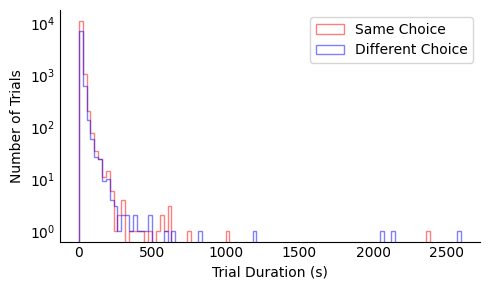

Bootstrap analysis for trial durations


  0%|          | 0/1000 [00:00<?, ?it/s]

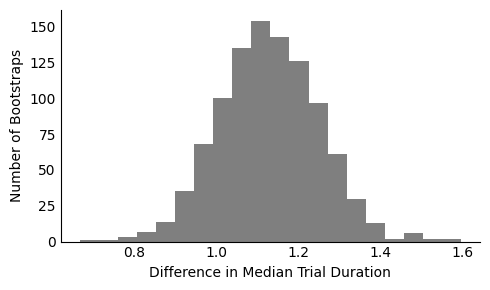

95% confidence interval = [0.89821942 1.3631191 ]
p-value = 1.0
Trial duration change for same choices: median = -7.34, mad = 30.28
Trial duration change for diff choices: median = -6.62, mad = 31.41


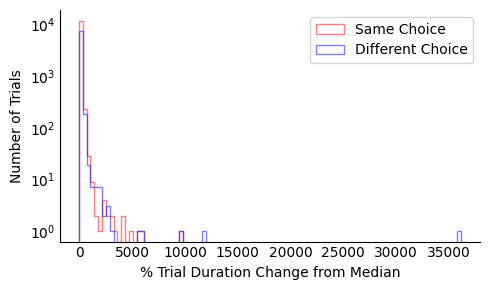

Bootstrap analysis for trial duration change


  0%|          | 0/1000 [00:00<?, ?it/s]

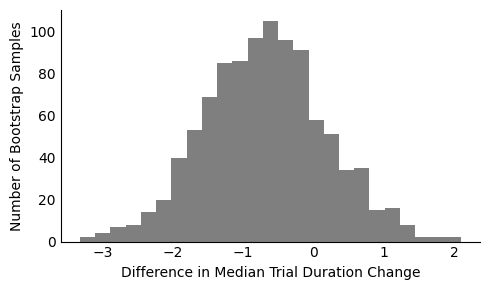

95% confidence interval = [-2.35206695  1.0642413 ]
p-value = 0.201


In [11]:
same = []
diff = []
same_change = []
diff_change = []

for i in range(N):
    # get choices and trial durations
    c = choice_data[i]
    r = reward_data[i]
    t = trial_duration_data[i]
    # get valid choices
    c = get_valid_data(c)
    r = get_valid_data(r)
    t = t[~np.isnan(t)]
    # assert that choices and trial durations are the same length
    assert len(c) == len(t) and len(r) == len(t), "Choice, reward, and trial duration data must be the same length."
    # get a rolling average of the trial durations (45 trials)
    t_ = np.convolve(t, np.ones(45)/45, mode='full')[45:len(t)]
    t_mid = np.median(t_)
    # find the first index where the trial duration is less than the median
    idx = np.where(t_ < t_mid)[0][0] + 45

    # keep only the trials before the first index
    c = c[30:idx]
    r = r[30:idx]
    t = t[30:idx]

    # loop over trials starting from the second trial
    for j in range(1,len(c)):
        t_past_window = t[max(0,j-45):j][1:]
        r_past_window = r[max(0,j-45):j][:-1]
        c_past_window = c[max(0,j-45):j][:-1]
        median_for_unrewarded = np.median(t_past_window[np.logical_and(r_past_window==0,c_past_window==c[j-1])])
        # if the current choice is the same as the previous choice
        if c[j] == c[j-1] and r[j-1] == 0:  # cannot consider the previous trial if it was rewarded due to local search increasing the trial duration
            same.append(t[j])
            if median_for_unrewarded == 0 or np.isnan(median_for_unrewarded):
                same_change.append(np.nan)
            else:
                same_change.append((t[j]-median_for_unrewarded)/median_for_unrewarded*100)
        elif c[j] != c[j-1] and r[j-1] == 0:
            diff.append(t[j])
            if median_for_unrewarded == 0 or np.isnan(median_for_unrewarded):
                diff_change.append(np.nan)
            else:
                diff_change.append((t[j]-median_for_unrewarded)/median_for_unrewarded*100)
same = np.array(same)
diff = np.array(diff)
same_change = np.array(same_change)
diff_change = np.array(diff_change)

# remove nans
same = same[~np.isnan(same)]
diff = diff[~np.isnan(diff)]
same_change = same_change[~np.isnan(same_change)]
diff_change = diff_change[~np.isnan(diff_change)]

# get overall maximum trial duration
min_trial_duration = np.min([np.min(same), np.min(diff)])
max_trial_duration = np.max([np.max(same), np.max(diff)])
bins = np.linspace(min_trial_duration, max_trial_duration, 100)

print("Trial durations for same choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(same), np.median(np.abs(same-np.median(same)))))
print("Trial durations for diff choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(diff), np.median(np.abs(diff-np.median(diff)))))

# plot histogram (step plot)
plt.figure(figsize=(5,3))
plt.hist(same, bins=bins, color='red', alpha=0.5, label='Same Choice', histtype='step')
plt.hist(diff, bins=bins, color='blue', alpha=0.5, label='Different Choice', histtype='step')
plt.xlabel('Trial Duration (s)')
plt.ylabel('Number of Trials')
plt.yscale('log')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

# minimum size of same and diff
print("Bootstrap analysis for trial durations")
n_bootstrap = 1000
diff_bootstrap = []
for i in tqdm(range(n_bootstrap)):
    bootstrap_same = np.random.choice(same, size=same.shape[0], replace=True)
    bootstrap_diff = np.random.choice(diff, size=diff.shape[0], replace=True)
    diff_bootstrap.append(np.median(bootstrap_same)-np.median(bootstrap_diff))
diff_bootstrap = np.array(diff_bootstrap)
# plot histogram
plt.figure(figsize=(5,3))
plt.hist(diff_bootstrap, bins=20, color='black', alpha=0.5)
plt.xlabel('Difference in Median Trial Duration')
plt.ylabel('Number of Bootstraps')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()
print("95% confidence interval = {}".format(np.percentile(diff_bootstrap, [2.5, 97.5])))
print("p-value = {}".format(np.mean(diff_bootstrap>0)))

# get overall maximum trial duration change and minimum trial duration change
min_trial_duration_change = np.min([np.min(same_change), np.min(diff_change)])
max_trial_duration_change = np.max([np.max(same_change), np.max(diff_change)])
bins = np.linspace(min_trial_duration_change, max_trial_duration_change, 100)

print("Trial duration change for same choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(same_change), np.median(np.abs(same_change-np.median(same_change)))))
print("Trial duration change for diff choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(diff_change), np.median(np.abs(diff_change-np.median(diff_change)))))

# plot histogram (step plot)
plt.figure(figsize=(5,3))
plt.hist(same_change, bins=bins, color='red', alpha=0.5, label='Same Choice', histtype='step')
plt.hist(diff_change, bins=bins, color='blue', alpha=0.5, label='Different Choice', histtype='step')
plt.xlabel('% Trial Duration Change from Median')
plt.ylabel('Number of Trials')
plt.yscale('log')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

# minimum size of same and diff
print("Bootstrap analysis for trial duration change")
n_bootstrap = 1000
diff_bootstrap = []
for i in tqdm(range(n_bootstrap)):
    bootstrap_same = np.random.choice(same_change, size=same_change.shape[0], replace=True)
    bootstrap_diff = np.random.choice(diff_change, size=diff_change.shape[0], replace=True)
    diff_bootstrap.append(np.median(bootstrap_same)-np.median(bootstrap_diff))
diff_bootstrap = np.array(diff_bootstrap)
# plot histogram
plt.figure(figsize=(5,3))
plt.hist(diff_bootstrap, bins=25, color='black', alpha=0.5)
plt.xlabel('Difference in Median Trial Duration Change')
plt.ylabel('Number of Bootstrap Samples')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()
print("95% confidence interval = {}".format(np.percentile(diff_bootstrap, [2.5, 97.5])))
print("p-value = {}".format(np.mean(diff_bootstrap>0)))

Trial durations for same choices: median = 9.58, mad = 3.09
Trial durations for diff choices: median = 8.99, mad = 2.70


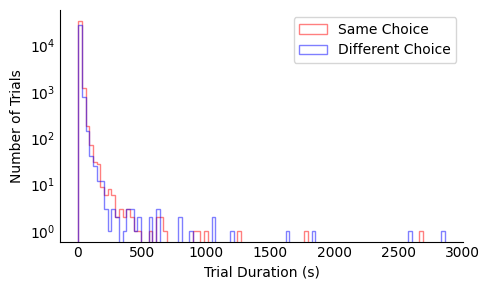

Bootstrap analysis for trial durations


  0%|          | 0/1000 [00:00<?, ?it/s]

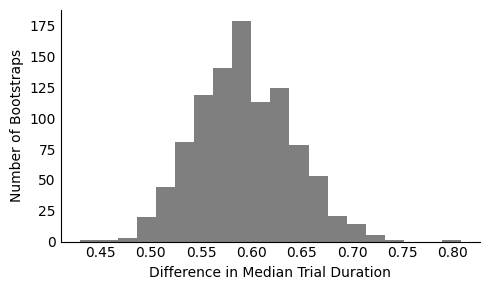

95% confidence interval = [0.50543189 0.68878417]
p-value = 1.0
Trial duration change for same choices: median = -1.91, mad = 27.12
Trial duration change for diff choices: median = -0.85, mad = 26.81


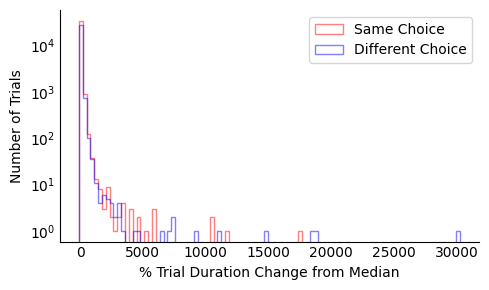

Bootstrap analysis for trial duration change


  0%|          | 0/1000 [00:00<?, ?it/s]

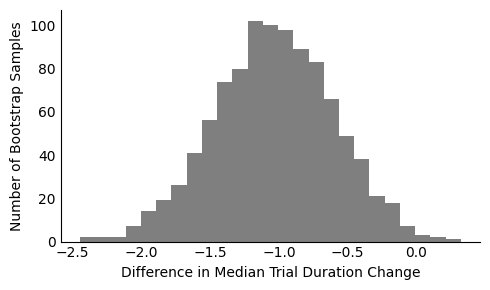

95% confidence interval = [-1.907515   -0.19371606]
p-value = 0.006


In [12]:
same = []
diff = []
same_change = []
diff_change = []

for i in range(N):
    # get choices and trial durations
    c = choice_data[i]
    r = reward_data[i]
    t = trial_duration_data[i]
    # get valid choices
    c = get_valid_data(c)
    r = get_valid_data(r)
    t = t[~np.isnan(t)]
    # assert that choices and trial durations are the same length
    assert len(c) == len(t) and len(r) == len(t), "Choice, reward, and trial duration data must be the same length."
    # get a rolling average of the trial durations (45 trials)
    t_ = np.convolve(t, np.ones(45)/45, mode='full')[45:len(t)]
    t_mid = np.median(t_)
    # find the first index where the trial duration is less than the median
    idx = np.where(t_ < t_mid)[0][0] + 45

    # keep only the trials before the first index
    c = c[idx:]
    r = r[idx:]
    t = t[idx:]

    # loop over trials starting from the second trial
    for j in range(1,len(c)):
        t_past_window = t[max(0,j-45):j][1:]
        r_past_window = r[max(0,j-45):j][:-1]
        c_past_window = c[max(0,j-45):j][:-1]
        median_for_unrewarded = np.median(t_past_window[np.logical_and(r_past_window==0,c_past_window==c[j-1])])
        # if the current choice is the same as the previous choice
        if c[j] == c[j-1] and r[j-1] == 0:  # cannot consider the previous trial if it was rewarded due to local search increasing the trial duration
            same.append(t[j])
            if median_for_unrewarded == 0 or np.isnan(median_for_unrewarded):
                same_change.append(np.nan)
            else:
                same_change.append((t[j]-median_for_unrewarded)/median_for_unrewarded*100)
        elif c[j] != c[j-1] and r[j-1] == 0:
            diff.append(t[j])
            if median_for_unrewarded == 0 or np.isnan(median_for_unrewarded):
                diff_change.append(np.nan)
            else:
                diff_change.append((t[j]-median_for_unrewarded)/median_for_unrewarded*100)
same = np.array(same)
diff = np.array(diff)
same_change = np.array(same_change)
diff_change = np.array(diff_change)

# remove nans
same = same[~np.isnan(same)]
diff = diff[~np.isnan(diff)]
same_change = same_change[~np.isnan(same_change)]
diff_change = diff_change[~np.isnan(diff_change)]

# get overall maximum trial duration
min_trial_duration = np.min([np.min(same), np.min(diff)])
max_trial_duration = np.max([np.max(same), np.max(diff)])
bins = np.linspace(min_trial_duration, max_trial_duration, 100)

print("Trial durations for same choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(same), np.median(np.abs(same-np.median(same)))))
print("Trial durations for diff choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(diff), np.median(np.abs(diff-np.median(diff)))))

# plot histogram (step plot)
plt.figure(figsize=(5,3))
plt.hist(same, bins=bins, color='red', alpha=0.5, label='Same Choice', histtype='step')
plt.hist(diff, bins=bins, color='blue', alpha=0.5, label='Different Choice', histtype='step')
plt.xlabel('Trial Duration (s)')
plt.ylabel('Number of Trials')
plt.yscale('log')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

# minimum size of same and diff
print("Bootstrap analysis for trial durations")
n_bootstrap = 1000
diff_bootstrap = []
for i in tqdm(range(n_bootstrap)):
    bootstrap_same = np.random.choice(same, size=same.shape[0], replace=True)
    bootstrap_diff = np.random.choice(diff, size=diff.shape[0], replace=True)
    diff_bootstrap.append(np.median(bootstrap_same)-np.median(bootstrap_diff))
diff_bootstrap = np.array(diff_bootstrap)
# plot histogram
plt.figure(figsize=(5,3))
plt.hist(diff_bootstrap, bins=20, color='black', alpha=0.5)
plt.xlabel('Difference in Median Trial Duration')
plt.ylabel('Number of Bootstraps')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()
print("95% confidence interval = {}".format(np.percentile(diff_bootstrap, [2.5, 97.5])))
print("p-value = {}".format(np.mean(diff_bootstrap>0)))

# get overall maximum trial duration change and minimum trial duration change
min_trial_duration_change = np.min([np.min(same_change), np.min(diff_change)])
max_trial_duration_change = np.max([np.max(same_change), np.max(diff_change)])
bins = np.linspace(min_trial_duration_change, max_trial_duration_change, 100)

print("Trial duration change for same choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(same_change), np.median(np.abs(same_change-np.median(same_change)))))
print("Trial duration change for diff choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(diff_change), np.median(np.abs(diff_change-np.median(diff_change)))))

# plot histogram (step plot)
plt.figure(figsize=(5,3))
plt.hist(same_change, bins=bins, color='red', alpha=0.5, label='Same Choice', histtype='step')
plt.hist(diff_change, bins=bins, color='blue', alpha=0.5, label='Different Choice', histtype='step')
plt.xlabel('% Trial Duration Change from Median')
plt.ylabel('Number of Trials')
plt.yscale('log')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

# minimum size of same and diff
print("Bootstrap analysis for trial duration change")
n_bootstrap = 1000
diff_bootstrap = []
for i in tqdm(range(n_bootstrap)):
    bootstrap_same = np.random.choice(same_change, size=same_change.shape[0], replace=True)
    bootstrap_diff = np.random.choice(diff_change, size=diff_change.shape[0], replace=True)
    diff_bootstrap.append(np.median(bootstrap_same)-np.median(bootstrap_diff))
diff_bootstrap = np.array(diff_bootstrap)
# plot histogram
plt.figure(figsize=(5,3))
plt.hist(diff_bootstrap, bins=25, color='black', alpha=0.5)
plt.xlabel('Difference in Median Trial Duration Change')
plt.ylabel('Number of Bootstrap Samples')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()
print("95% confidence interval = {}".format(np.percentile(diff_bootstrap, [2.5, 97.5])))
print("p-value = {}".format(np.mean(diff_bootstrap>0)))

In [13]:
same = []
diff = []
same_change = []
diff_change = []

for i in range(N):
    # get choices and trial durations
    c = choice_data[i]
    r = reward_data[i]
    t = trial_duration_data[i]
    # get valid choices
    c = get_valid_data(c)
    r = get_valid_data(r)
    t = t[~np.isnan(t)]
    # assert that choices and trial durations are the same length
    assert len(c) == len(t) and len(r) == len(t), "Choice, reward, and trial duration data must be the same length."
    # get a rolling average of the trial durations (45 trials)
    t_ = np.convolve(t, np.ones(45)/45, mode='full')[45:len(t)]
    t_mid = np.median(t_)
    # find the first index where the trial duration is less than the median
    idx = np.where(t_ < t_mid)[0][0] + 45

    # keep only the trials before the first index
    c = c[idx:]
    r = r[idx:]
    t = t[idx:]

    # loop over trials starting from the second trial
    for j in range(1,len(c)):
        # if the current choice is the same as the previous choice
        if c[j] == c[j-1] and r[j-1] == 0:  # cannot consider the previous trial if it was rewarded due to local search increasing the trial duration
            same.append(t[j])
            same_change.append((t[j]-np.median(t[max(0,j-45):j]))/np.median(t[max(0,j-45):j])*100)
        elif c[j] != c[j-1] and r[j-1] == 0:
            diff.append(t[j])
            diff_change.append((t[j]-np.median(t[max(0,j-45):j]))/np.median(t[max(0,j-45):j])*100)
same = np.array(same)
diff = np.array(diff)
same_change = np.array(same_change)
diff_change = np.array(diff_change)

Trial durations for same choices: median = 9.58, mad = 3.09
Trial durations for diff choices: median = 8.99, mad = 2.70


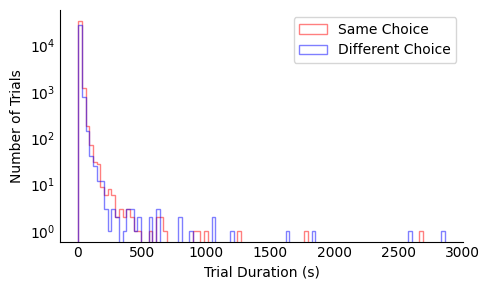

Bootstrap analysis for trial durations


  0%|          | 0/1000 [00:00<?, ?it/s]

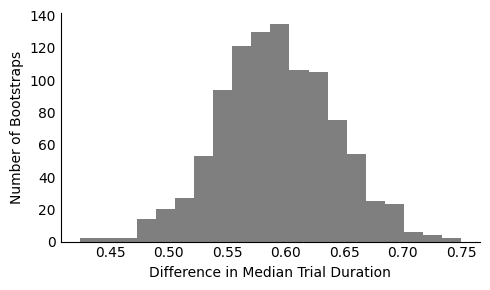

95% confidence interval = [0.49569471 0.69084879]
p-value = 1.0
Trial duration change for same choices: median = -14.97, mad = 23.72
Trial duration change for diff choices: median = -14.41, mad = 23.74


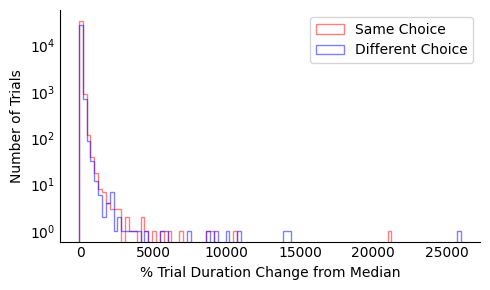

Bootstrap analysis for trial duration change


  0%|          | 0/1000 [00:00<?, ?it/s]

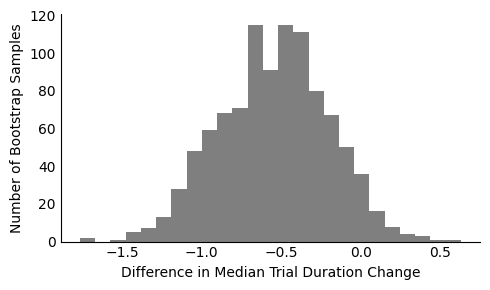

95% confidence interval = [-1.20376191  0.0905231 ]
p-value = 0.051


In [12]:
# get overall maximum trial duration
min_trial_duration = np.min([np.min(same), np.min(diff)])
max_trial_duration = np.max([np.max(same), np.max(diff)])
bins = np.linspace(min_trial_duration, max_trial_duration, 100)

print("Trial durations for same choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(same), np.median(np.abs(same-np.median(same)))))
print("Trial durations for diff choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(diff), np.median(np.abs(diff-np.median(diff)))))

# plot histogram (step plot)
plt.figure(figsize=(5,3))
plt.hist(same, bins=bins, color='red', alpha=0.5, label='Same Choice', histtype='step')
plt.hist(diff, bins=bins, color='blue', alpha=0.5, label='Different Choice', histtype='step')
plt.xlabel('Trial Duration (s)')
plt.ylabel('Number of Trials')
plt.yscale('log')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

# minimum size of same and diff
print("Bootstrap analysis for trial durations")
n_bootstrap = 1000
diff_bootstrap = []
for i in tqdm(range(n_bootstrap)):
    bootstrap_same = np.random.choice(same, size=same.shape[0], replace=True)
    bootstrap_diff = np.random.choice(diff, size=diff.shape[0], replace=True)
    diff_bootstrap.append(np.median(bootstrap_same)-np.median(bootstrap_diff))
diff_bootstrap = np.array(diff_bootstrap)
# plot histogram
plt.figure(figsize=(5,3))
plt.hist(diff_bootstrap, bins=20, color='black', alpha=0.5)
plt.xlabel('Difference in Median Trial Duration')
plt.ylabel('Number of Bootstraps')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()
print("95% confidence interval = {}".format(np.percentile(diff_bootstrap, [2.5, 97.5])))
print("p-value = {}".format(np.mean(diff_bootstrap>0)))

# get overall maximum trial duration change and minimum trial duration change
min_trial_duration_change = np.min([np.min(same_change), np.min(diff_change)])
max_trial_duration_change = np.max([np.max(same_change), np.max(diff_change)])
bins = np.linspace(min_trial_duration_change, max_trial_duration_change, 100)

print("Trial duration change for same choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(same_change), np.median(np.abs(same_change-np.median(same_change)))))
print("Trial duration change for diff choices: median = {:0.2f}, mad = {:0.2f}".format(np.median(diff_change), np.median(np.abs(diff_change-np.median(diff_change)))))

# plot histogram (step plot)
plt.figure(figsize=(5,3))
plt.hist(same_change, bins=bins, color='red', alpha=0.5, label='Same Choice', histtype='step')
plt.hist(diff_change, bins=bins, color='blue', alpha=0.5, label='Different Choice', histtype='step')
plt.xlabel('% Trial Duration Change from Median')
plt.ylabel('Number of Trials')
plt.yscale('log')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

# minimum size of same and diff
print("Bootstrap analysis for trial duration change")
n_bootstrap = 1000
diff_bootstrap = []
for i in tqdm(range(n_bootstrap)):
    bootstrap_same = np.random.choice(same_change, size=same_change.shape[0], replace=True)
    bootstrap_diff = np.random.choice(diff_change, size=diff_change.shape[0], replace=True)
    diff_bootstrap.append(np.median(bootstrap_same)-np.median(bootstrap_diff))
diff_bootstrap = np.array(diff_bootstrap)
# plot histogram
plt.figure(figsize=(5,3))
plt.hist(diff_bootstrap, bins=25, color='black', alpha=0.5)
plt.xlabel('Difference in Median Trial Duration Change')
plt.ylabel('Number of Bootstrap Samples')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()
print("95% confidence interval = {}".format(np.percentile(diff_bootstrap, [2.5, 97.5])))
print("p-value = {}".format(np.mean(diff_bootstrap>0)))